<a href="https://colab.research.google.com/github/chethanhn29/Advanced-House-Price-Prediction/blob/main/Water_Bottle_Classification_model_Copy1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import all the Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")



### Set all the Constants

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=200

### Import data into tensorflow dataset object

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("d:/DRDO/Chethan/task/1/george_test_task",
#dataset = tf.keras.preprocessing.image_dataset_from_directory("C:/Users/Saftey Team/Downloads"),https://drive.google.com/drive/folders/13fV31epAzaZyPNN5jAQRzUnaAWX_A3DS?usp=share_link
                                                                                                                                                                                                                                  
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5698 files belonging to 2 classes.


In [4]:
class_names = dataset.class_names
class_names

['george', 'no_george']

In [5]:
## Image Shape and Labels 
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 0 0 1 0 0 0 1 1 1 1 0 1 0 0 1 0 1 1 0 0 0 0 1 1 1 0 0 1 0 1 0]


As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels 

### Visualize some of the images from our dataset

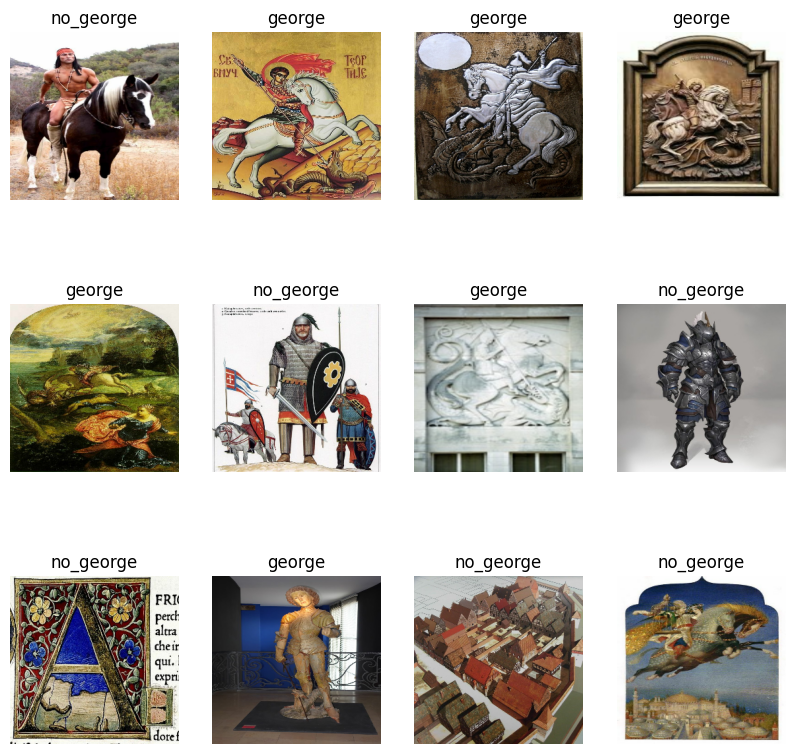

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [7]:
## Size of Dataset of 32 Batch
len(dataset)

179

In [8]:
## To split the Data as Train,test and Validation data
def get_dataset_partitions_tf(ds, train_split=0.75, val_split=0.125, test_split=0.125, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [10]:
## Get Train,Test and Validation data
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

## Size of Train,Validation and Test data
len(train_ds),len(val_ds),len(test_ds)

(134, 22, 23)

### Cache, Shuffle, and Prefetch the Dataset

In [11]:
# Cache and shuffle the training dataset to improve training efficiency
# and prevent the model from memorizing the order of examples
# Use AUTOTUNE to dynamically adjust buffer sizes for prefetching, optimizing performance.

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. 
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

This will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [13]:

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255)
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [32]:
seed = (1, 2)
# Define the data augmentation pipeline using tf.keras.Sequential
data_augmentation = tf.keras.Sequential([
    # Randomly flip images horizontally and vertically
    layers.RandomFlip("horizontal_and_vertical"),
    # Randomly rotate images by up to 20 degrees
    layers.RandomRotation(0.2),
    # Apply random brightness adjustment
    layers.Lambda(lambda x: tf.image.stateless_random_brightness(x, max_delta=0.5,seed=seed)),
    # Apply random contrast adjustment
    layers.Lambda(lambda x: tf.image.stateless_random_contrast(x, lower=0.1, upper=0.9, seed=seed)),
    # Randomly flip images left-right
    layers.Lambda(lambda x: tf.image.stateless_random_flip_left_right(x, seed=seed)),
    # Randomly flip images up-down
    layers.Lambda(lambda x: tf.image.stateless_random_flip_up_down(x, seed=seed)),
    # Apply random hue adjustment
    layers.Lambda(lambda x: tf.image.stateless_random_hue(x, max_delta=0.2, seed=seed)),
    # Apply random saturation adjustment
    layers.Lambda(lambda x: tf.image.stateless_random_saturation(x, lower=0.5, upper=1.5, seed=seed)),
])


### Augmented images for 1 image

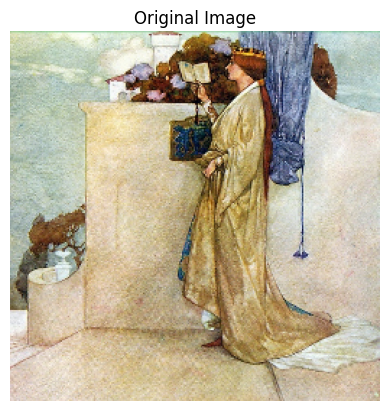

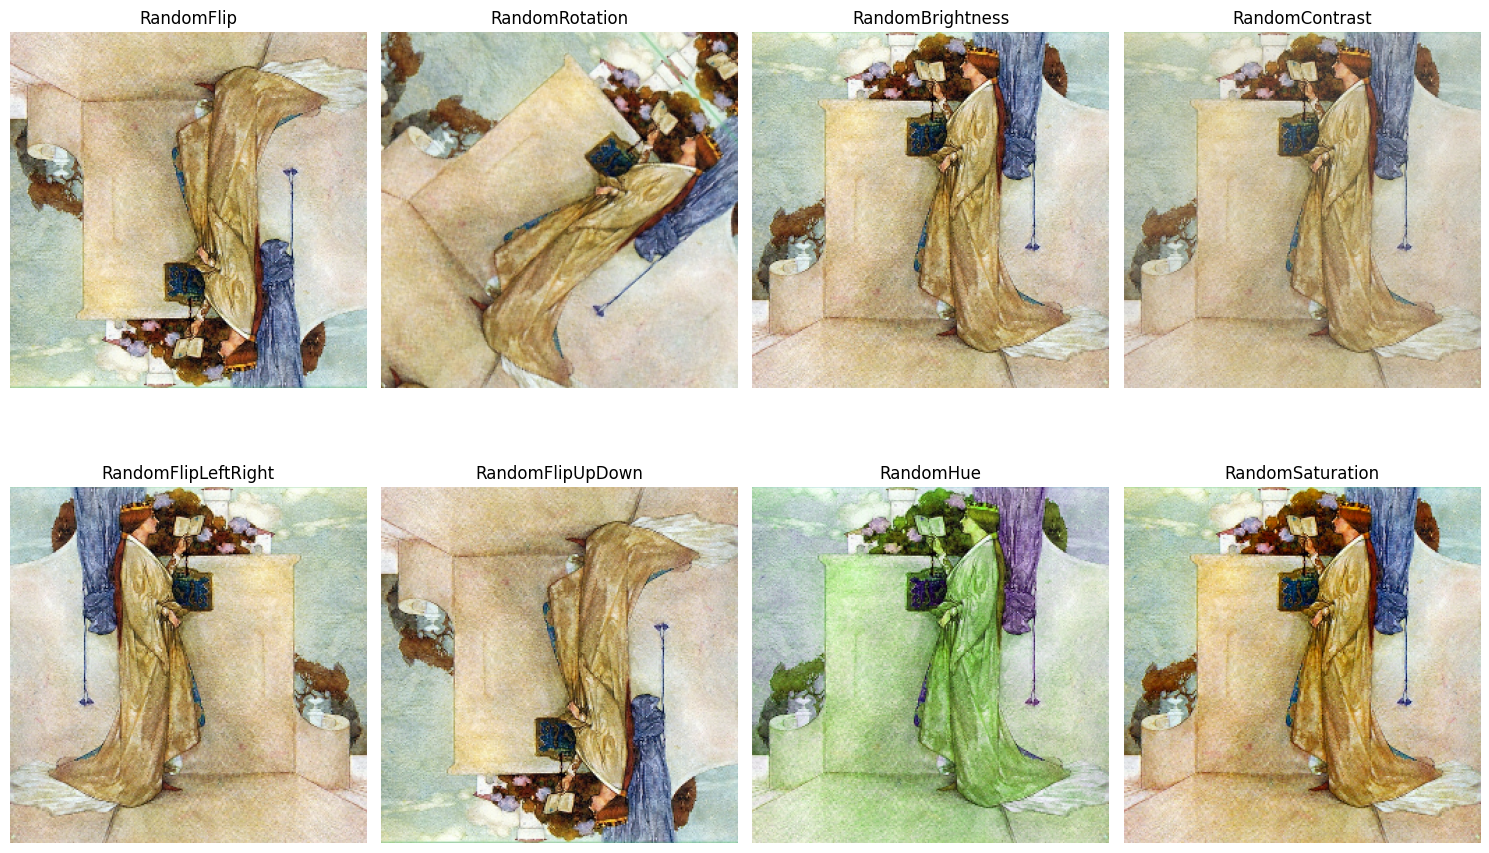

In [125]:
# Load a sample image for augmentation
for image_batch, labels_batch in dataset.take(1):
    img = image_batch[10]

plt.imshow(img .numpy().astype("uint8"))
plt.title("Original Image")
plt.axis("off")
    
plt.figure(figsize=(15, 10))  # Increased figure height to accommodate two rows
num_layers = len(data_augmentation.layers)
num_cols = num_layers // 2 + num_layers % 2  # Number of columns in each row

# Define the labels for each augmentation operation
augmentation_labels = ["RandomFlip","RandomRotation","RandomBrightness","RandomContrast","RandomFlipLeftRight","RandomFlipUpDown","RandomHue","RandomSaturation"]

for i, (layer, label) in enumerate(zip(data_augmentation.layers, augmentation_labels)):
    augmented_img = layer(tf.expand_dims(img, 0), training=True)
    plt.subplot(2, num_cols, i + 1)  # Using two rows
    plt.imshow(tf.squeeze(augmented_img).numpy().astype("uint8"))
    plt.title(label)
    plt.axis("off")

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [126]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

In [119]:

from tensorflow.keras import layers, models, optimizers 
from tensorflow.keras.applications import VGG16
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import TensorBoard


base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

# Freeze the convolutional base
base_model.trainable = False

# Create a new model on top of the pre-trained base model
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    base_model,
    layers.Flatten(),
    layers.Dense(256),
    BatchNormalization(),  # Add BatchNormalization layer
    layers.ReLU(),         # Add ReLU activation function
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax')
])

# Define the  decay schedule
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=5, min_lr=0.001)
# Define the TensorBoard callback
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)

# Compile the model
model.compile( optimizer='adam',
            loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=50,
                    callbacks=[reduce_lr, tensorboard_callback], 
                    verbose=1)
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_ds)

print(f'Test Accuracy: {test_accuracy}')

Epoch 1/50
134/134 [==============================] - 53s 368ms/step - loss: 0.7251 - accuracy: 0.6999 - val_loss: 1.8305 - val_accuracy: 0.5895 - lr: 0.0010
Epoch 2/50
134/134 [==============================] - 49s 361ms/step - loss: 0.5290 - accuracy: 0.7487 - val_loss: 0.6031 - val_accuracy: 0.7230 - lr: 0.0010
Epoch 3/50
134/134 [==============================] - 50s 370ms/step - loss: 0.4749 - accuracy: 0.7839 - val_loss: 0.6012 - val_accuracy: 0.7230 - lr: 0.0010
Epoch 4/50
134/134 [==============================] - 50s 370ms/step - loss: 0.4546 - accuracy: 0.7938 - val_loss: 0.6244 - val_accuracy: 0.7259 - lr: 0.0010
Epoch 5/50
134/134 [==============================] - 51s 379ms/step - loss: 0.4185 - accuracy: 0.8112 - val_loss: 0.7254 - val_accuracy: 0.6903 - lr: 0.0010
Epoch 6/50
134/134 [==============================] - 50s 367ms/step - loss: 0.4130 - accuracy: 0.8112 - val_loss: 0.7504 - val_accuracy: 0.6832 - lr: 0.0010
Epoch 7/50
134/134 [==============================] 

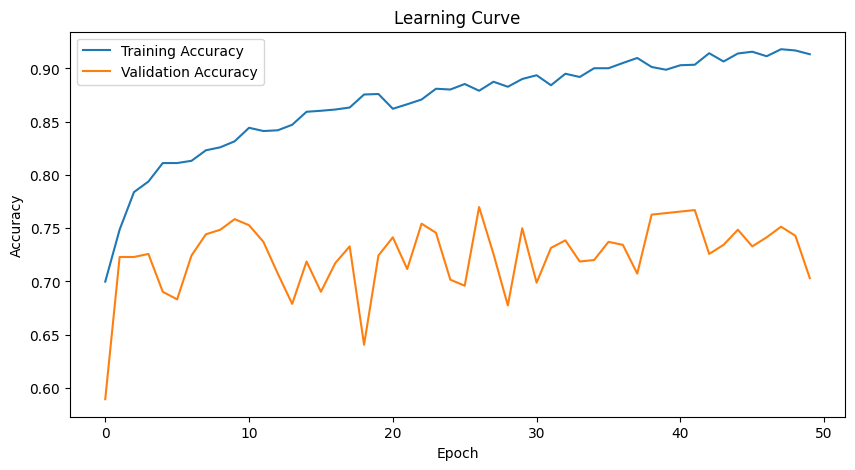

In [120]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc

# Plot the learning curve (training and validation accuracy)
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

23/23 [==============================] - 4s 182ms/step


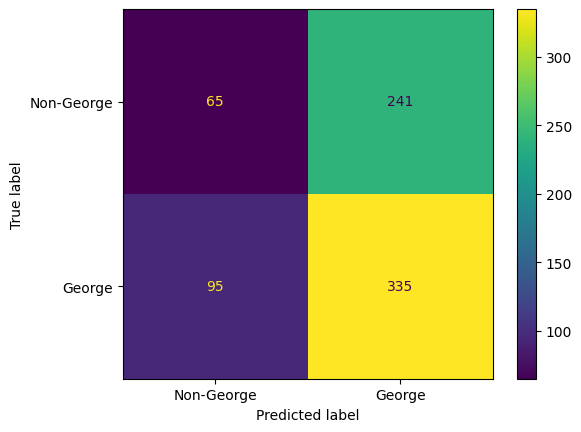

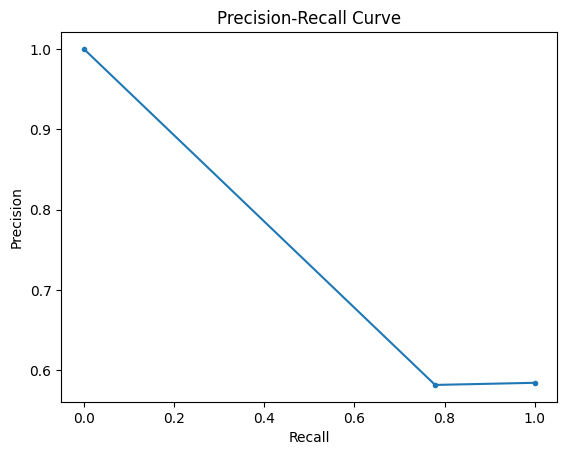

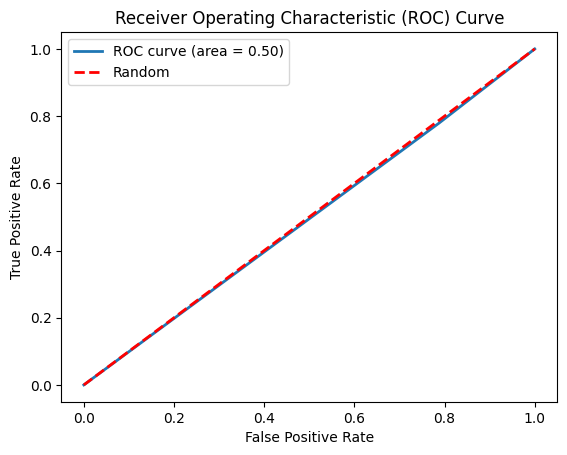

In [121]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict probabilities for the test dataset
test_probabilities = model.predict(test_ds)

# Get predicted classes based on the maximum probability
test_predictions = tf.argmax(test_probabilities, axis=1)

# Get true labels for the test dataset
test_labels = []
for images, labels in test_ds:
    test_labels.extend(labels.numpy())

# Plot the confusion matrix
conf_mat = confusion_matrix(test_labels, test_predictions)
# Display confusion matrix with labels
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=['Non-George', 'George'])
disp.plot()
plt.show()


# Plot the precision-recall curve
precision, recall, _ = precision_recall_curve(test_labels, test_predictions)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Plot the ROC curve
fpr, tpr, _ = roc_curve(test_labels, test_predictions)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


In [122]:
## Perfomance of Model on Test data
scores = model.evaluate(test_ds)

23/23 [==============================] - 4s 184ms/step - loss: 0.9626 - accuracy: 0.7364


**You can see above that we get 100.00% accuracy for our test dataset. This is considered to be a pretty good accuracy**

In [123]:
## Loss ,Accuracy Results for the Test data
scores

[0.9626233577728271, 0.7364130616188049]

### Run prediction on a sample image

first image to predict
actual label: george
1/1 [==============================] - 0s 196ms/step
predicted label: george


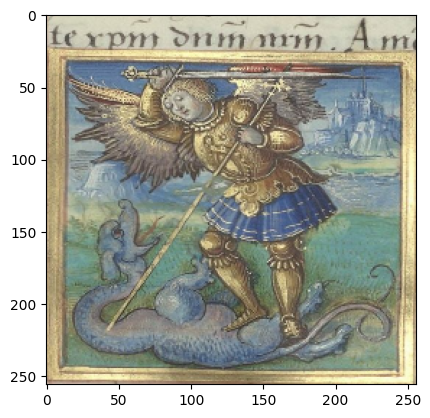

In [105]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [106]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 [==============================] - 0s 20ms/step


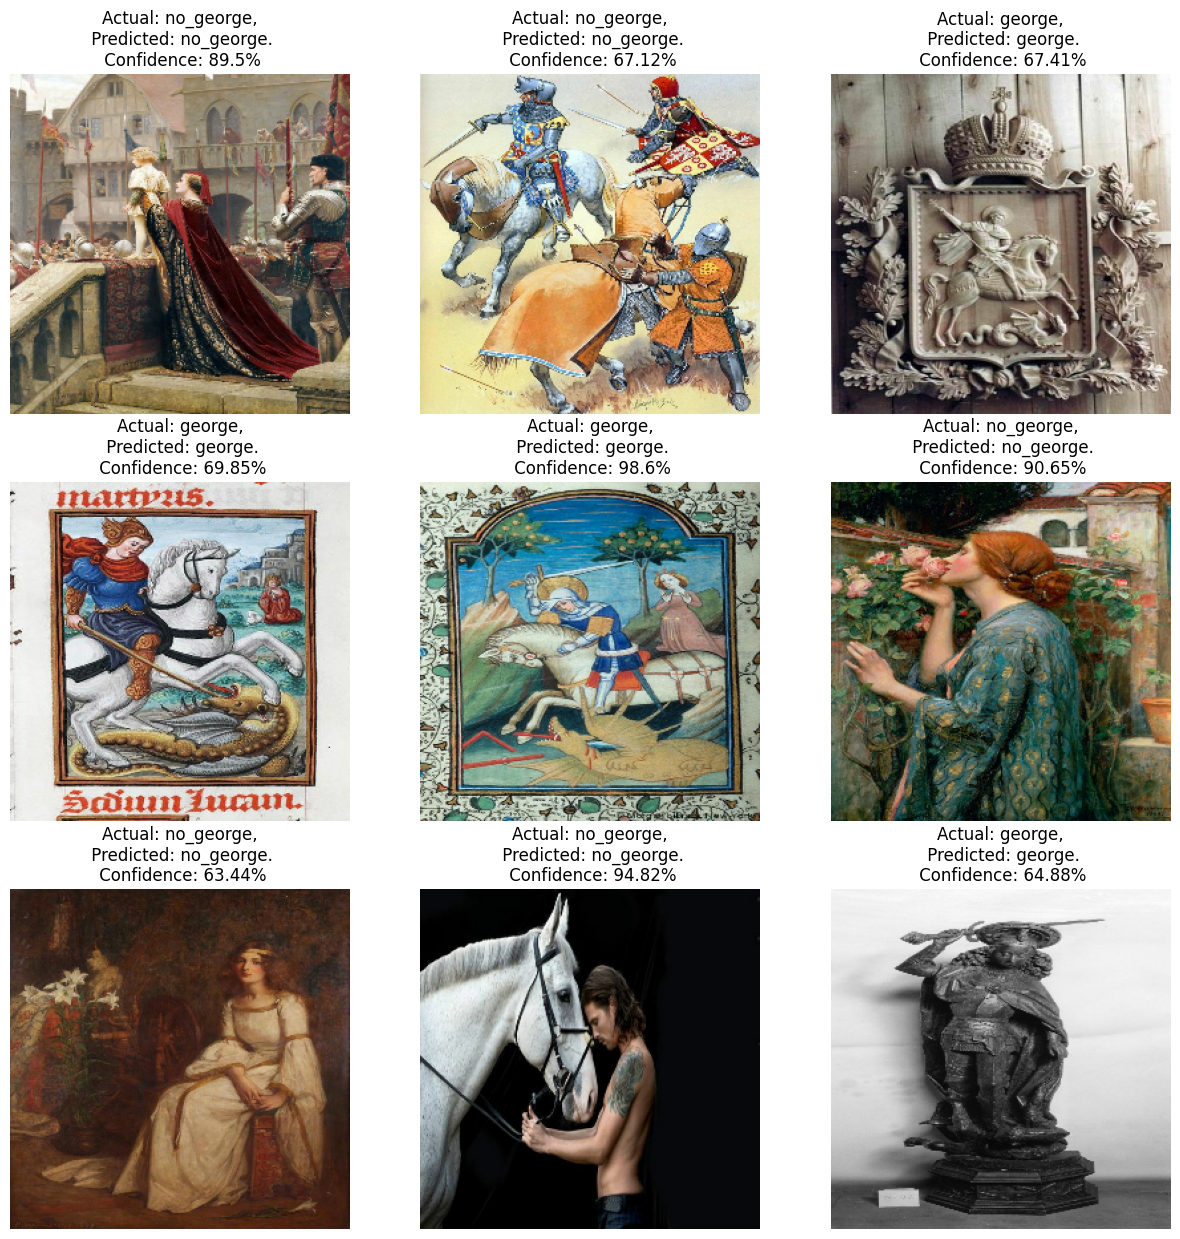

In [107]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")